# Projet Télédétection Avancée UE : 901_2  + Qualité et Fouille UE : 906

NOM: DIALLO
Prénom: Djiby

Données utilisées: Bretagne_24-25 et échantillons PI_strates_Bretagne_32630


# Introduction Générale

La classification d’images de télédétection constitue une étape clé pour transformer des données brutes en cartes thématiques exploitables. Elle permet d’identifier et de discriminer différents types de surfaces (sols nus, végétation, zones artificialisées, cultures, etc.) à partir de leurs signatures spectrales. Les méthodes de classification supervisée, et notamment celles basées sur l’apprentissage automatique, offrent aujourd’hui des performances élevées et une grande capacité de généralisation, à condition d’être correctement paramétrées et validées.

Ce projet s’inscrit dans cette dynamique et vise à mettre en œuvre une chaîne complète de traitement d’images allant du prétraitement des données jusqu’à la production d’une image classifiée finale constituée des classes comme du sol nu, herbe, landes et arbre. Il mobilise des outils de traitement numérique et des bibliothèques scientifiques afin de manipuler les données raster, entraîner un modèle de classification, évaluer l’importance des variables utilisées et générer une sortie cartographique cohérente et exploitable dans un SIG.

Une attention particulière est portée à la gestion des valeurs NoData, à la cohérence radiométrique et à la compatibilité des résultats avec les logiciels de cartographie tels que QGIS. L’objectif final est de produire une carte fiable et interprétable, tout en respectant les bonnes pratiques en télédétection et en traitement des données géospatiales.

Ce travail permet ainsi de consolider des compétences à la fois théoriques et pratiques en télédétection, en analyse spatiale et en programmation appliquée, tout en répondant à des enjeux concrets de production et de qualité de l’information géographique.

### IMPORTS ET CONFIGURATION

In [1]:
import sys
sys.path.append("/home/onyxia/work")

import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal
from libsigma import read_and_write as rw
from libsigma import plots

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

import my_function as mf

### Définition des chemins et configuration

In [2]:
# Définition des chemins
BASE = "/home/onyxia/work"
DATA = os.path.join(BASE, "data", "projet_eval")
RESULTS = os.path.join(BASE, "results")
FIG = os.path.join(RESULTS, "figure")
IMG_DIR = os.path.join(BASE, "img")

# Création des dossiers si nécessaire
os.makedirs(RESULTS, exist_ok=True)
os.makedirs(FIG, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)
sortie_matrix = os.path.join(FIG, "matrice_confusion.png")
sortie_qualite = os.path.join(FIG, "qualite_classes.png")

# Chemins des données
vector_samples = os.path.join(DATA, "PI_strates_bretagne_32630.shp")
ref_image = os.path.join(DATA, "bretagne_24-25_B03.tif")

# Configuration
bandes_classif = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]

DATES_BRETAGNE_24_25 = [
    "2025-03-31", "2025-04-10", "2025-05-15",
    "2025-06-17", "2025-07-12", "2025-08-10"
]

# Dictionnaires pour les classes
class_names = {1: "Sol Nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}
color_map = {2: "limegreen", 3: "purple", 4: "darkgreen"}

print(" Configuration terminée")
print(f" Données : {DATA}")
print(f" Résultats : {RESULTS}")



 Configuration terminée
 Données : /home/onyxia/work/data/projet_eval
 Résultats : /home/onyxia/work/results


# PARTIE 1 - ANALYSE DES ÉCHANTILLONS

Description de la méthode

L’objectif est d’évaluer la représentativité et l’équilibre des échantillons d’apprentissage avant l’entraînement du modèle.

Les échantillons proviennent du fichier vectoriel PI_strates_bretagne_32630.shp et sont décrits par l’attribut strate (2 : Herbe, 3 : Landes, 4 : Arbre).

Deux analyses sont réalisées :

comptage du nombre de polygones par classe à partir des données vectorielles ;

comptage du nombre de pixels par classe après rasterisation des polygones (résolution 10 m, EPSG:32630, NoData = 0) en utilisant la bande B03 comme raster de référence.

Les résultats sont visualisés sous forme de diagrammes en bâtons enregistrés dans results/figure.

Cette double analyse permet d’identifier d’éventuels déséquilibres entre classes susceptibles d’influencer l’apprentissage du classifieur.

### Comptage des polygones par classe

In [3]:
gdf = gpd.read_file(vector_samples)
print(gdf.head())
counts_poly = gdf["strate"].value_counts().sort_index()

classes = counts_poly.index.tolist()
values = counts_poly.values
print(counts_poly)

   id  strate      comment                                           geometry
0   1       3  lande basse  POLYGON ((441224.58 5366298.317, 441224.779 53...
1   2       3  lande basse  POLYGON ((441649.972 5366251.139, 441650.172 5...
2   3       3  lande basse  POLYGON ((441383.597 5366193.034, 441384.395 5...
3   4       2         None  POLYGON ((441336.658 5366402.088, 441337.257 5...
4   5       2         None  POLYGON ((441062.121 5366343.165, 441062.919 5...
strate
2     86
3    121
4     71
Name: count, dtype: int64


### Création du diagramme en bâtons - Polygones

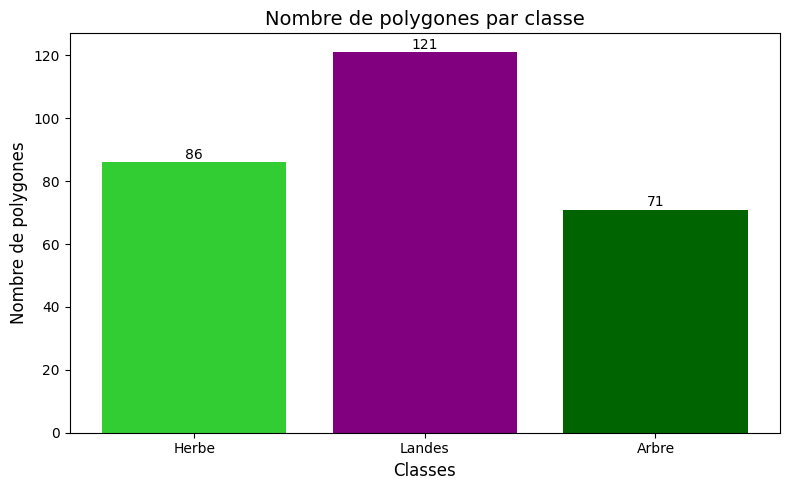

 Graphique sauvegardé : /home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png


In [4]:
plt.figure(figsize=(8, 5))
classes_poly = counts_poly.index.tolist()
values_poly = counts_poly.values

# Filtrer les classes présentes
labels_poly = []
colors_poly = []
values_filtered = []

for c in classes_poly:
    if c in class_names and c in color_map:
        labels_poly.append(class_names[c])
        colors_poly.append(color_map[c])
        values_filtered.append(counts_poly[c])

bars = plt.bar(labels_poly, values_filtered, color=colors_poly)

plt.xlabel("Classes", fontsize=12)
plt.ylabel("Nombre de polygones", fontsize=12)
plt.title("Nombre de polygones par classe", fontsize=14)

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
output_poly = os.path.join(FIG, "diag_baton_nb_poly_by_class.png")
plt.savefig(output_poly, dpi=150)
plt.show()
print(f" Graphique sauvegardé : {output_poly}")

#  PARTIE 2 — RASTERISATION DES ÉCHANTILLONS

Description de la méthode
Les polygones d’échantillons sont convertis en image raster afin de permettre l’extraction automatique des signatures spectrales pixel par pixel afin de les compter.

La rasterisation est réalisée :

en utilisant une image Sentinel-2 (bande B03) comme raster de référence ;

avec une résolution spatiale de 10 m ;

dans le système de projection EPSG:32630 ;

en utilisant l’attribut strate comme valeur de pixel.

Les pixels ne correspondant à aucun échantillon sont codés avec la valeur 0 (NoData).


###  Rasterisation

In [5]:
out_raster = os.path.join(RESULTS, "strates_rasterise.tif")

mf.rasterize_vector(
    vector_path=vector_samples,
    ref_raster_path=ref_image,  
    output_path=out_raster,
    attribute="strate"
)

print("Raster créé :", out_raster)



Rasterisation terminée : /home/onyxia/work/results/strates_rasterise.tif
Raster créé : /home/onyxia/work/results/strates_rasterise.tif


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


### Comptage des pixels par classe

In [6]:
arr = rw.load_img_as_array(out_raster).squeeze()

vals, counts = np.unique(arr[arr > 0], return_counts=True)

print("\nNombre de pixels par classe :")
for v, c in zip(vals, counts):
    print(f"Classe {v} : {c} pixels")




Nombre de pixels par classe :
Classe 2 : 1022 pixels
Classe 3 : 1599 pixels
Classe 4 : 1218 pixels


### Création du diagramme en bâtons - Pixels

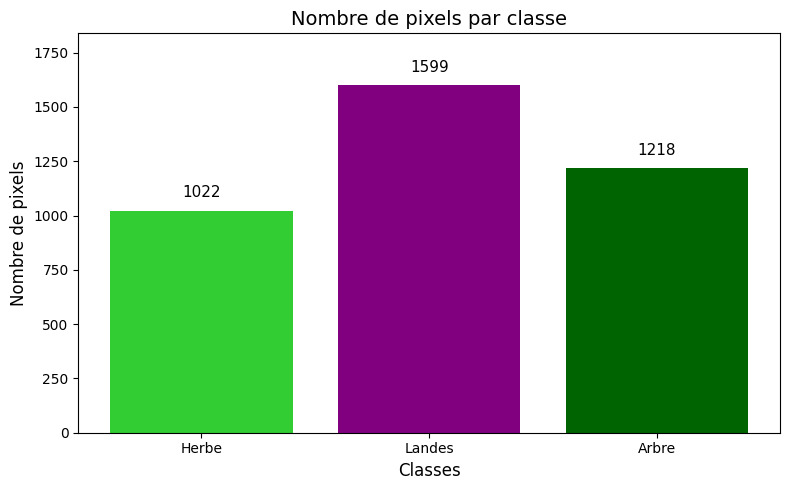

Graphique sauvegardé : /home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.png


In [7]:
plt.figure(figsize=(8, 5))

labels_pix = [class_names[c] for c in vals]
colors_pix = [color_map[c] for c in vals]
counts_pix = counts

bars = plt.bar(labels_pix, counts_pix, color=colors_pix)

plt.xlabel("Classes", fontsize=12)
plt.ylabel("Nombre de pixels", fontsize=12)
plt.title("Nombre de pixels par classe", fontsize=14)

offset = 0.03 * max(counts_pix)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + offset,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=11
    )

plt.ylim(0, max(counts_pix) * 1.15)

plt.tight_layout()

output_pix = os.path.join(FIG, "diag_baton_nb_pix_by_class.png")
plt.savefig(output_pix, dpi=150)
plt.show()

print(f"Graphique sauvegardé : {output_pix}")


**Observations factuelles** :

Distribution des polygones :
- Herbe : 86 polygones (31%)
- Landes : 121 polygones (43%) — classe majoritaire
- Arbre : 71 polygones (26%)
- Sol Nu : absent

Distribution des pixels :
- Herbe : 1022 pixels (27%)
- Landes : 1599 pixels (42%) — classe majoritaire
- Arbre : 1218 pixels (31%)
- Sol Nu : absent

Le comptage des pixels issus de la rasterisation des polygones montre que la classe Landes est la plus représentée, suivie par la classe Arbre et la classe Herbe.

**Implications méthodologiques** :
- Nécessité d'utiliser une **métrique pondérée** (F1-score) lors de l'optimisation pour éviter un biais en faveur de Landes
- **Stratification obligatoire** lors du split train/test pour préserver les proportions de classes


# PARTIE 3A - CALCUL DE L'INDICE ARI

L’indice ARI est calculé pour chaque date à partir des bandes B03 et B05, pixel par pixel, avec gestion des valeurs NoData et des divisions invalides.

La série temporelle obtenue est enregistrée sous forme d’un raster multibande (10 m, EPSG:32630, float32, NoData = −9999).

Pour chaque strate, les valeurs d’ARI sont extraites à partir des pixels d’échantillons rasterisés afin de calculer la moyenne et l’écart-type à chaque date. Les profils temporels sont ensuite visualisés sous forme de courbes avec enveloppes d’écart-type.

Période d'étude : Mars à août 2025 (cycle végétatif complet)

### Chargement et calcul de l'ARI

In [8]:
stack_B03 = os.path.join(DATA, "bretagne_24-25_B03.tif")
stack_B05 = os.path.join(DATA, "bretagne_24-25_B05.tif")

print("Chargement des bandes B03 et B05...")
B03 = rw.load_img_as_array(stack_B03).astype("float32")
B05 = rw.load_img_as_array(stack_B05).astype("float32")

print(f"  Shape B03 : {B03.shape}")
print(f"  Shape B05 : {B05.shape}")

print("Calcul de l'ARI...")
ARI = mf.calculate_ari(B03, B05, nodata=-9999)

print(f"  Shape ARI : {ARI.shape}")
print(f"  Valeurs min/max : {np.nanmin(ARI[ARI != -9999]):.3f} / {np.nanmax(ARI[ARI != -9999]):.3f}")

Chargement des bandes B03 et B05...
  Shape B03 : (612, 1533, 6)
  Shape B05 : (612, 1533, 6)
Calcul de l'ARI...
  Shape ARI : (612, 1533, 6)
  Valeurs min/max : -0.594 / 0.488


### Sauvegarde de la série temporelle ARI

In [9]:
out_ARI = os.path.join(RESULTS, "ARI_serie_temp.tif")
mf.save_ari_series(ARI, stack_B03, out_ARI, nodata=-9999)

Série temporelle ARI sauvegardée : /home/onyxia/work/results/ARI_serie_temp.tif


### Vérification des caractéristiques du raster ARI créé

In [10]:
ds = gdal.Open(out_ARI)

gt = ds.GetGeoTransform()

print("Résolution X :", gt[1])
print("Résolution Y :", abs(gt[5]))
print("Projection :", ds.GetProjection())
print("Type :", gdal.GetDataTypeName(ds.GetRasterBand(1).DataType))
print("NoData :", ds.GetRasterBand(1).GetNoDataValue())

ds = None

Résolution X : 10.0
Résolution Y : 10.0
Projection : PROJCS["WGS 84 / UTM zone 30N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32630"]]
Type : Float32
NoData : -9999.0


# PARTIE 3B - ANALYSE PHÉNOLOGIQUE

### Extraction des statistiques par classe

In [11]:
ARI_loaded = rw.load_img_as_array(out_ARI)
strates = rw.load_img_as_array(out_raster).squeeze()

classes = [2, 3, 4]  # Herbe, Landes, Arbre
nb_classes = len(classes)
nb_dates = ARI_loaded.shape[2]

# Initialisation des tableaux
moyennes = np.zeros((nb_classes, nb_dates))
ecarts_types = np.zeros((nb_classes, nb_dates))

# Calcul des statistiques
for i, classe in enumerate(classes):
    mask_classe = (strates == classe)

    for d in range(nb_dates):
        valeurs = ARI_loaded[:, :, d][mask_classe]
        valeurs = valeurs[valeurs != -9999]

        if valeurs.size > 0:
            moyennes[i, d] = np.mean(valeurs)
            ecarts_types[i, d] = np.std(valeurs)
        else:
            moyennes[i, d] = np.nan
            ecarts_types[i, d] = np.nan

print("Statistiques ARI calculées pour chaque classe et chaque date")


Statistiques ARI calculées pour chaque classe et chaque date


### Création du graphique de phénologie

La figure suivante présente l’évolution temporelle de l’indice ARI moyen par strate, ainsi que l’écart-type intra-classe. L’objectif est d’évaluer la capacité de l’ARI à discriminer la classe Landes.


=== Statistiques globales ARI par strate ===
Strate 2:
  min : 0.053645983
  max : 0.22484577
  mean: 0.15296303
  std : 0.02722788
Strate 3:
  min : 0.03926704
  max : 0.25989395
  mean: 0.14291848
  std : 0.021305667


Strate 4:
  min : 0.025869751
  max : 0.25177497
  mean: 0.11744908
  std : 0.029166808


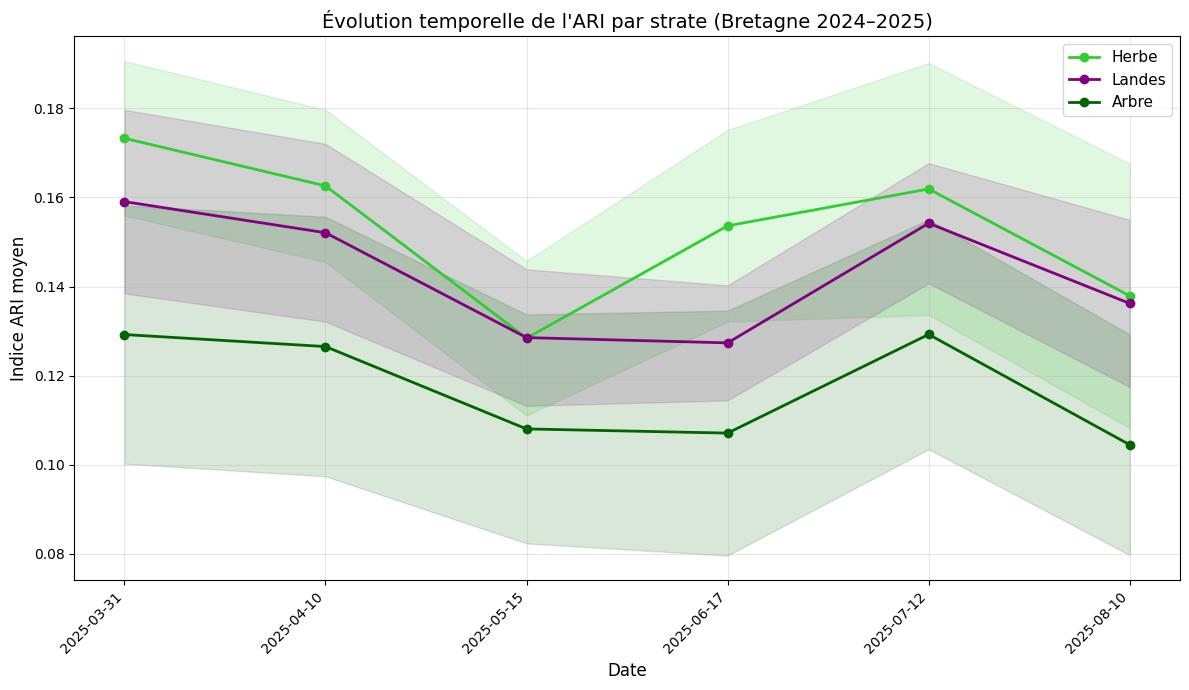

In [12]:
# Dates correspondant aux 6 acquisitions Sentinel-2 de la série Bretagne 2024–2025
dates = ["2025-03-31", "2025-04-10", "2025-05-15", 
         "2025-06-17", "2025-07-12", "2025-08-10"]

plt.figure(figsize=(12, 7))

labels = ["Herbe", "Landes", "Arbre"]
colors = ["limegreen", "purple", "darkgreen"]

print("\n=== Statistiques globales ARI par strate ===")

for i, classe in enumerate(classes):
    mask_classe = (strates == classe)

    valeurs_classe = ARI_loaded[mask_classe]
    valeurs_classe = valeurs_classe[valeurs_classe != -9999]

    print(f"Strate {classe}:")
    print("  min :", np.nanmin(valeurs_classe))
    print("  max :", np.nanmax(valeurs_classe))
    print("  mean:", np.nanmean(valeurs_classe))
    print("  std :", np.nanstd(valeurs_classe))


for i in range(3):
    plt.plot(dates, moyennes[i, :],
             label=labels[i],
             color=colors[i],
             marker='o',
             linewidth=2,
             markersize=6)

    plt.fill_between(dates,
                     moyennes[i, :] - ecarts_types[i, :],
                     moyennes[i, :] + ecarts_types[i, :],
                     alpha=0.15,
                     color=colors[i])

plt.xlabel("Date", fontsize=12)
plt.ylabel("Indice ARI moyen", fontsize=12)
plt.title("Évolution temporelle de l'ARI par strate (Bretagne 2024–2025)", fontsize=14)
plt.legend(loc="best", fontsize=11)
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG + "/ARI_series.png", dpi=150, bbox_inches="tight")
plt.show()

**Observations factuelles** :

Plage de valeurs : ARI varie entre 0.10 et 0.18 pour l'ensemble des strates
Écarts-types élevés : variabilité intra-classe de 15-20% des moyennes (hétérogénéité spectrale)
Profils temporels très similaires : courbes Herbe et Landes quasi-confondues
Classe Arbre légèrement séparée : valeurs plus faibles mais chevauchement des enveloppes d'écart-type
Aucune période discriminante : à aucun moment de l'année l'ARI ne sépare clairement les Landes

Conclusion : L'indice ARI seul ne permet pas une discrimination satisfaisante de la classe Landes. La forte similarité spectrale et phénologique entre Herbe et Landes justifie l'utilisation d'une approche multivariée exploitant l'ensemble des bandes spectrales et la dimension temporelle.

# PARTIE 4 - CLASSIFICATION SUPERVISÉE

### Description de la méthode

**Objectif** : Produire une carte de strates végétales par classification supervisée Random Forest, en exploitant la dimension spectro-temporelle des données Sentinel-2.

**Approche méthodologique** :

Construction du stack spectral : empilement des 10 bandes Sentinel-2 sur 6 dates → 60 variables par pixel
Extraction des échantillons : pixels annotés (strates rasterisées) → matrices X (features) et Y (labels)
Split stratifié : 70% apprentissage / 30% test (préserve proportions de classes)
Optimisation hyperparamètres : GridSearchCV avec validation croisée 5-fold stratifiée
Entraînement final : modèle avec hyperparamètres optimaux sur 100% des données
Production carte : classification de l'image complète et application d'un masque spatial

**Choix du classifieur Random Forest** :

Robustesse au bruit spectral (votes d'ensemble d'arbres)
Capacité à gérer haute dimensionnalité (60 variables)
Performance sur problèmes non-linéaires (signatures spectrales complexes)
Interprétabilité : estimation directe de l'importance des variables

**Justification de l'approche multitemporelle** :

Exploitation des cycles phénologiques différenciés (Herbe vs Landes vs Arbre)
Les bandes red-edge (B05-B07, B8A) capturent la dynamique chlorophyllienne
Les bandes SWIR (B11-B12) sont sensibles à la structure et l'humidité de la végétation
La dimension temporelle compense les limitations de l'ARI mono-bande

### Fusion des bandes spectrales Sentinel-2

In [13]:
tif_list = [
    DATA + "/bretagne_24-25_B02.tif",
    DATA + "/bretagne_24-25_B03.tif",
    DATA + "/bretagne_24-25_B04.tif",
    DATA + "/bretagne_24-25_B05.tif",
    DATA + "/bretagne_24-25_B06.tif",
    DATA + "/bretagne_24-25_B07.tif",
    DATA + "/bretagne_24-25_B08.tif",
    DATA + "/bretagne_24-25_B8A.tif",
    DATA + "/bretagne_24-25_B11.tif",
    DATA + "/bretagne_24-25_B12.tif",
]

stack = []

for tif in tif_list:
    ds = gdal.Open(tif)
    arr = ds.ReadAsArray()              # (dates, rows, cols)
    arr = np.transpose(arr, (1, 2, 0))  # (rows, cols, dates)
    stack.append(arr)

image_stack = np.concatenate(stack, axis=2)

print("Stack spectral :", image_stack.shape)  # (rows, cols, 60)


Stack spectral : (612, 1533, 60)


### Sauvegarde du raster multibande final

In [14]:
out_stack = RESULTS + "/bretagne_stack_spectral.tif"

mf.save_multiband_raster(
    image_stack,
    tif_list[0],
    out_stack,
    nodata=-9999
)

print("Raster multibande sauvegardé :", out_stack)

output_multibande = out_stack


Raster multibande sauvegardé : /home/onyxia/work/results/bretagne_stack_spectral.tif
Raster multibande sauvegardé : /home/onyxia/work/results/bretagne_stack_spectral.tif


### Vérification des bandes

In [15]:
ds = gdal.Open(output_multibande)
print("Nombre de bandes :", ds.RasterCount)
ordered_bands = []

for b in ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]:
    for d in range(1, 7):
        ordered_bands.append(f"{b}_t{d}")
for i in range(1, ds.RasterCount + 1):
    arr = ds.GetRasterBand(i).ReadAsArray().astype("float32")
    arr[arr == -9999] = np.nan

    print(
        f"Bande {i:02d} ({ordered_bands[i-1]}): "
        f"min={np.nanmin(arr):.3f}, "
        f"max={np.nanmax(arr):.3f}, "
        f"mean={np.nanmean(arr):.3f}"
    )

ds = None


Nombre de bandes : 60
Bande 01 (B02_t1): min=1040.000, max=5144.000, mean=1398.158
Bande 02 (B02_t2): min=1133.000, max=4740.000, mean=1476.020
Bande 03 (B02_t3): min=763.000, max=18816.000, mean=1416.091
Bande 04 (B02_t4): min=1027.000, max=6680.000, mean=1334.132
Bande 05 (B02_t5): min=998.000, max=4776.000, mean=1334.678
Bande 06 (B02_t6): min=1072.000, max=5944.000, mean=1358.103
Bande 07 (B03_t1): min=1091.000, max=5332.000, mean=1655.757
Bande 08 (B03_t2): min=1176.000, max=5108.000, mean=1736.609
Bande 09 (B03_t3): min=1129.000, max=14744.000, mean=1682.440
Bande 10 (B03_t4): min=1031.000, max=9376.000, mean=1622.792
Bande 11 (B03_t5): min=1100.000, max=5220.000, mean=1603.801
Bande 12 (B03_t6): min=1135.000, max=6248.000, mean=1612.979
Bande 13 (B04_t1): min=1074.000, max=5340.000, mean=1656.484
Bande 14 (B04_t2): min=1131.000, max=5144.000, mean=1703.061
Bande 15 (B04_t3): min=1075.000, max=6560.000, mean=1512.534
Bande 16 (B04_t4): min=1007.000, max=10520.000, mean=1470.885
B

### Préparation des données d’apprentissage

In [16]:
X_image = rw.load_img_as_array(out_stack)
y_raster = rw.load_img_as_array(out_raster).squeeze()

X, Y, mask = mf.prepare_training_data(X_image, y_raster)
Y = Y.ravel()

print("X shape :", X.shape)
print("Y shape :", Y.shape)
print("Classes :", np.unique(Y))


X shape : (3839, 60)
Y shape : (3839,)
Classes : [2 3 4]


### Séparation apprentissage / test

**Justification** :

70/30 : compromis standard (suffisamment de données pour entraînement et test robuste)
Stratification : préserve proportions 27% / 42% / 31% dans train et test
Random state fixé : reproductibilité des résultats

In [17]:
# Split stratifié train / test (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.3,
    stratify=Y,        # conserve proportions des classes
    random_state=42
)

print("Train :", X_train.shape, y_train.shape)
print("Test  :", X_test.shape, y_test.shape)

# Vérification distribution des classes
print("\nDistribution classes TRAIN:")
for c, n in zip(*np.unique(y_train, return_counts=True)):
    print(f"Classe {c} : {n}")

print("\nDistribution classes TEST:")
for c, n in zip(*np.unique(y_test, return_counts=True)):
    print(f"Classe {c} : {n}")


Train : (2687, 60) (2687,)
Test  : (1152, 60) (1152,)

Distribution classes TRAIN:
Classe 2 : 715
Classe 3 : 1119
Classe 4 : 853

Distribution classes TEST:
Classe 2 : 307
Classe 3 : 480
Classe 4 : 365


### GridSearch

### Grille d’hyperparamètres

| Paramètre          | Valeurs testées              | Justification |
|--------------------|------------------------------|---------------|
| `n_estimators`     | 50, 100, 150, 200, 300        | Nombre d’arbres. Augmente la stabilité mais le coût de calcul. La plage choisie permet un compromis performance / temps. |
| `max_depth`        | None, 10, 15, 20              | Profondeur des arbres. *None* = profondeur illimitée (relations complexes). Les valeurs limitées permettent une régularisation et réduisent le sur-apprentissage. |
| `max_features`     | None, sqrt, log2              | Sous-échantillonnage des variables à chaque séparation, favorisant la diversité des arbres et la robustesse du modèle. |
| `min_samples_leaf` | 1, 5                          | Nombre minimal d’échantillons par feuille. Une valeur plus élevée lisse le modèle et réduit l’influence du bruit spectral. |


### Justification de la stratégie de validation

| Paramètre        | Valeur              | Justification |
|------------------|---------------------|---------------|
| `K (n_splits)`   | 5                   | Compromis optimal : 600 entraînements (5 folds × 120 configurations) en ~30–45 min. Un K=10 doublerait le temps de calcul sans gain significatif de performance. |
| Stratification   | Oui                 | Maintient les proportions de classes (27 % Herbe, 42 % Landes, 31 % Arbre) dans chaque fold, ce qui est crucial en présence de déséquilibre. |
| Shuffle          | True                | La randomisation évite les biais liés à l’ordre spatial des échantillons (autocorrélation spatiale). |
| Métrique         | F1-score pondéré    | Tient compte du déséquilibre des classes (pondération par support), équilibre précision et rappel, et est plus robuste que l’accuracy ou le F1-macro. |

Cette stratégie garantit une évaluation robuste et non biaisée des hyperparamètres.

In [18]:
# ============================
# Définition du modèle
# ============================

rf_base = RandomForestClassifier(
    random_state=0,
    n_jobs=-1
)

# ============================
# Grille d’hyperparamètres
# ============================

param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [None, 10, 15, 20],
    "max_features": [None, "sqrt", "log2"],
    "min_samples_leaf": [1, 5],
}


# ============================
# Validation croisée stratifiée
# ============================

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=0
)

# ============================
# GridSearch
# ============================

grid = GridSearchCV(
    estimator= rf_base,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_weighted",   # adapté aux classes déséquilibrées
    n_jobs=-1,
    verbose=2
)

print("Lancement du GridSearch...")
grid.fit(X_train, y_train)

# ============================
# Résultats CV
# ============================

print("\nMeilleurs hyperparamètres trouvés :")
print(grid.best_params_)

print(f"Score CV moyen (F1 pondéré) : {grid.best_score_:.3f}")

# ============================
# Modèle final
# ============================

best_model = grid.best_estimator_

# ============================
# Évaluation sur jeu de test
# ============================

y_pred = best_model.predict(X_test)

acc_test = accuracy_score(y_test, y_pred)
f1_test  = f1_score(y_test, y_pred, average="weighted")

print("\n=== Évaluation sur le jeu de test ===")
print(f"Accuracy test : {acc_test:.3f}")
print(f"F1 pondéré test : {f1_test:.3f}")


Lancement du GridSearch...
Fitting 5 folds for each of 120 candidates, totalling 600 fits


[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  12.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  12.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  12.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  13.1s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=50; total time=  13.3s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  22.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  22.6s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  23.4s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  23.5s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, n_estimators=100; total time=  2

### Validation croisée

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

list_acc = []
list_f1 = []
list_cm = []
list_report = []

print("\n=== Validation croisée (5 folds) ===")

for fold, (train_idx, val_idx) in enumerate(cv.split(X, Y)):
    X_train_cv = X[train_idx]
    y_train_cv = Y[train_idx]
    X_val_cv = X[val_idx]
    y_val_cv = Y[val_idx]
    
    best_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = best_model.predict(X_val_cv)
    
    acc = accuracy_score(y_val_cv, y_pred_cv)
    f1 = f1_score(y_val_cv, y_pred_cv, average='weighted')
    cm = confusion_matrix(y_val_cv, y_pred_cv)
    report = classification_report(y_val_cv, y_pred_cv, output_dict=True)
    
    list_acc.append(acc)
    list_f1.append(f1)
    list_cm.append(cm)
    list_report.append(pd.DataFrame(report).T)
    
    print(f"Fold {fold+1}: Acc={acc:.3f}, F1={f1:.3f}")


=== Validation croisée (5 folds) ===
Fold 1: Acc=0.970, F1=0.970
Fold 2: Acc=0.987, F1=0.987
Fold 3: Acc=0.973, F1=0.973
Fold 4: Acc=0.984, F1=0.984
Fold 5: Acc=0.969, F1=0.969


### Calcul des statistiques

In [20]:
mean_accuracy = np.mean(list_acc)
std_accuracy = np.std(list_acc)
mean_f1 = np.mean(list_f1)
std_f1 = np.std(list_f1)

print(f"\n=== Résultats validation croisée ===")
print(f"Accuracy moyenne : {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"F1 pondéré moyen : {mean_f1:.3f} ± {std_f1:.3f}")


=== Résultats validation croisée ===
Accuracy moyenne : 0.977 ± 0.008
F1 pondéré moyen : 0.977 ± 0.008


### Résultats de la classification

Les performances du modèle Random Forest ont été évaluées à la fois sur un jeu de test indépendant (30 % des données) et par validation croisée stratifiée à 5 plis.

Sur le jeu de test, les résultats obtenus sont :

**Accuracy test** : 0.980

**F1-score pondéré test** : 0.980

La validation croisée à 5 plis montre des performances élevées et stables :

**Accuracy moyenne** : 0.977 ± 0.008

**F1-score pondéré moyen** : 0.977 ± 0.008

La faible variabilité entre les plis et la proximité entre les performances en validation croisée et sur le jeu de test indiquent une bonne capacité de généralisation du modèle et l’absence de sur-apprentissage.


### Importance des variables

In [21]:
feature_names = []

# bandes spectrales
for bande in bandes_classif:
    for date in DATES_BRETAGNE_24_25:
        feature_names.append(f"{bande}_{date}")


print("Nombre de variables :", len(feature_names))
print("Nombre d'importances :", len(best_model.feature_importances_))


# Tableau des importances
importances = best_model.feature_importances_

df_importance = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 des variables les plus importantes :")
print(df_importance.head(10).to_string(index=False))

Nombre de variables : 60
Nombre d'importances : 60

Top 10 des variables les plus importantes :
      Variable  Importance
B08_2025-04-10    0.069463
B07_2025-04-10    0.058990
B05_2025-06-17    0.057259
B08_2025-03-31    0.049972
B8A_2025-04-10    0.047904
B04_2025-05-15    0.043851
B06_2025-03-31    0.040430
B05_2025-08-10    0.040402
B12_2025-05-15    0.038419
B8A_2025-03-31    0.036119


### Graphique importance des variables

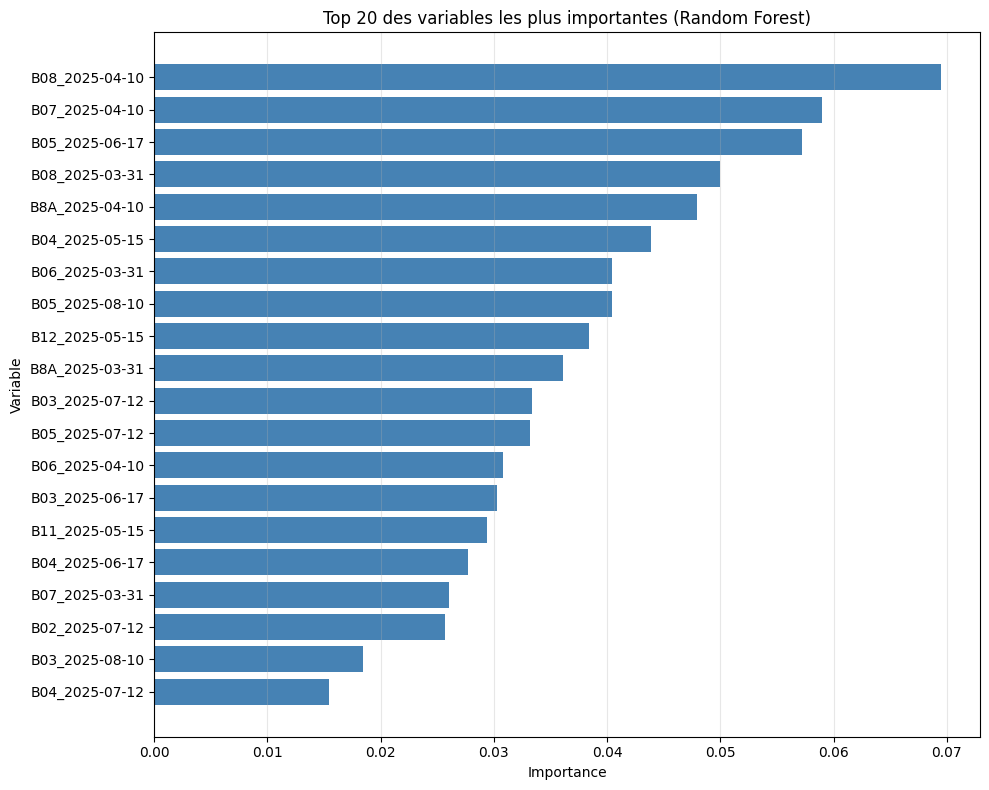

Figure importance sauvegardée : /home/onyxia/work/results/figure/feature_importance.png


In [22]:
plt.figure(figsize=(10, 8))
top_20 = df_importance.head(20)

plt.barh(top_20["Variable"], top_20["Importance"], color="steelblue")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.title("Top 20 des variables les plus importantes (Random Forest)")
plt.gca().invert_yaxis()
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()

output_importance = os.path.join(FIG, "feature_importance.png")
plt.savefig(output_importance, dpi=150)
plt.show()

print(f"Figure importance sauvegardée : {output_importance}")


### Analyse de l’importance des variables

Top 3 des variables les plus importantes :

**B08_2025-04-10** : 0.069

**B07_2025-04-10** : 0.059

**B05_2025-06-17** : 0.057

Ces trois variables correspondent respectivement **au proche infrarouge** (B08) et à des bandes du **red-edge** (B07, B05), acquises à des périodes clés du cycle végétatif printanier et estival.

Observations factuelles

Domination des bandes red-edge (B05, B06, B07, B8A) : ces bandes figurent majoritairement parmi les variables les plus importantes, traduisant leur forte sensibilité à la chlorophylle et à la structure foliaire.

Importance marquée du proche infrarouge (B08) : plusieurs dates de la bande B08 apparaissent dans le top 10, soulignant son rôle clé pour la caractérisation de la biomasse et de la vigueur végétative.

Contribution significative des bandes SWIR (B11, B12) : ces bandes apportent une information complémentaire liée à la teneur en eau et à la structure de la canopée.

Faible contribution des bandes visibles (B02, B03, B04) : bien que présentes ponctuellement, elles montrent un pouvoir discriminant plus limité pour différencier des classes majoritairement végétalisées.


### Exactitude globale moyenne + écart-type

In [23]:
array_report = np.array(list_report)

mean_report = array_report.mean(axis=0)
std_report  = array_report.std(axis=0)

array_cm = np.array(list_cm)

print("Accuracy moyenne :", mean_accuracy)
print("Écart-type accuracy :", std_accuracy)



Accuracy moyenne : 0.97655435136897
Écart-type accuracy : 0.0076007829989222135


L’exactitude globale moyenne obtenue par validation croisée est de **0.977 ± 0.008**, indiquant des performances élevées et une faible variabilité entre les plis.

Ce faible écart-type (< 1 %) traduit une **bonne stabilité du modèle** et confirme sa capacité à généraliser face à différents découpages des données d’apprentissage.


### Tableaux rapports moyens (precision/recall/f1)

In [24]:
a_report = list_report[0]

mean_df_report = pd.DataFrame(
    mean_report,
    index=a_report.index,
    columns=a_report.columns
)

std_df_report = pd.DataFrame(
    std_report,
    index=a_report.index,
    columns=a_report.columns
)

display(mean_df_report)
display(std_df_report)



,precision,recall,f1-score,support
2,0.990238,0.986294,0.988244,204.400000
3,0.972133,0.978109,0.975086,319.800000
4,0.971140,0.966329,0.968667,243.600000
accuracy,0.976554,0.976554,0.976554,0.976554
macro avg,0.977837,0.976911,0.977332,767.800000
weighted avg,0.976634,0.976554,0.976552,767.800000


,precision,recall,f1-score,support
2,0.007444,0.004809,0.004696,0.489898
3,0.011645,0.005938,0.007806,0.400000
4,0.009889,0.017504,0.012017,0.489898
accuracy,0.007601,0.007601,0.007601,0.007601
macro avg,0.007031,0.007641,0.007348,0.400000
weighted avg,0.007551,0.007601,0.007606,0.400000


### Analyse des performances par classe

Les rapports moyens issus de la validation croisée montrent des performances élevées et homogènes pour l’ensemble des classes, avec des **F1-scores compris entre 0.97 et 0.99** et des écarts-types très faibles (< 0.01).

La classe **Herbe (strate 2)** présente les meilleures performances, avec un **F1-score moyen de 0.988**, traduisant une excellente séparabilité spectrale.

La classe **Landes (strate 3)** affiche un **F1-score moyen de 0.975**, indiquant une très bonne reconnaissance, avec quelques confusions résiduelles.

La classe **Arbre (strate 4)** présente un **F1-score moyen de 0.969**, légèrement inférieur à celui des Landes, ce qui suggère des confusions ponctuelles entre formations arborées et landes hautes.

La faible dispersion des scores entre les plis confirme la **stabilité et la robustesse du modèle**.


### Matrice de confusion

Matrice de confusion sauvegardée : /home/onyxia/work/results/figure/matrice_confusion.png
Index du DataFrame :
['2', '3', '4', 'accuracy', 'macro avg', 'weighted avg']

Nombre de classes filtrées : 3


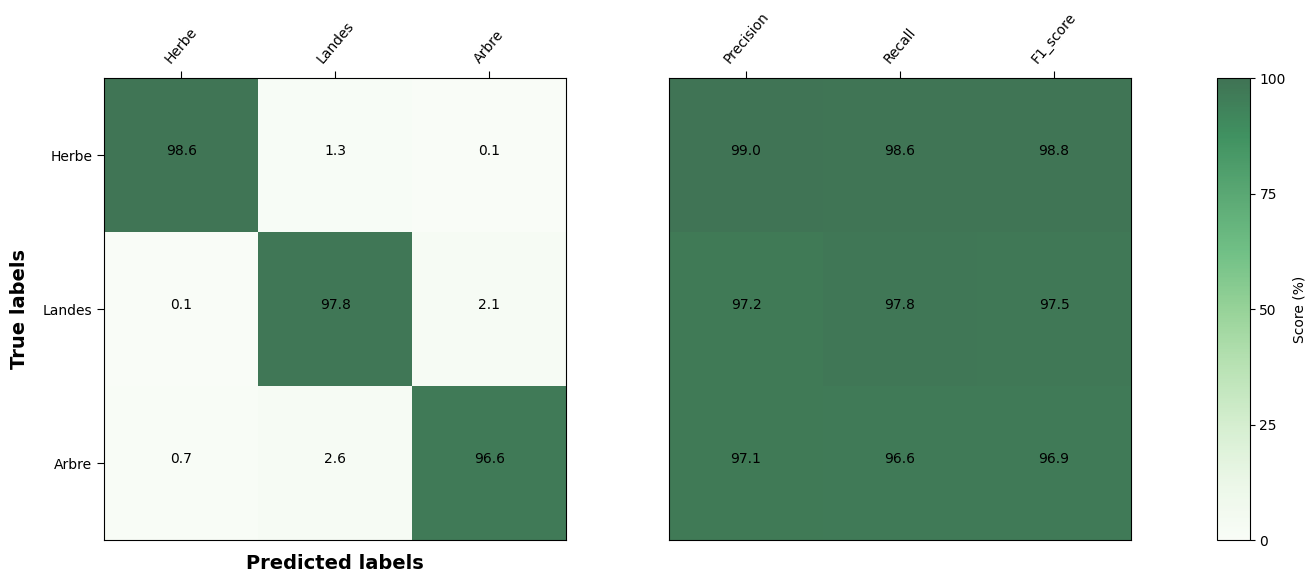

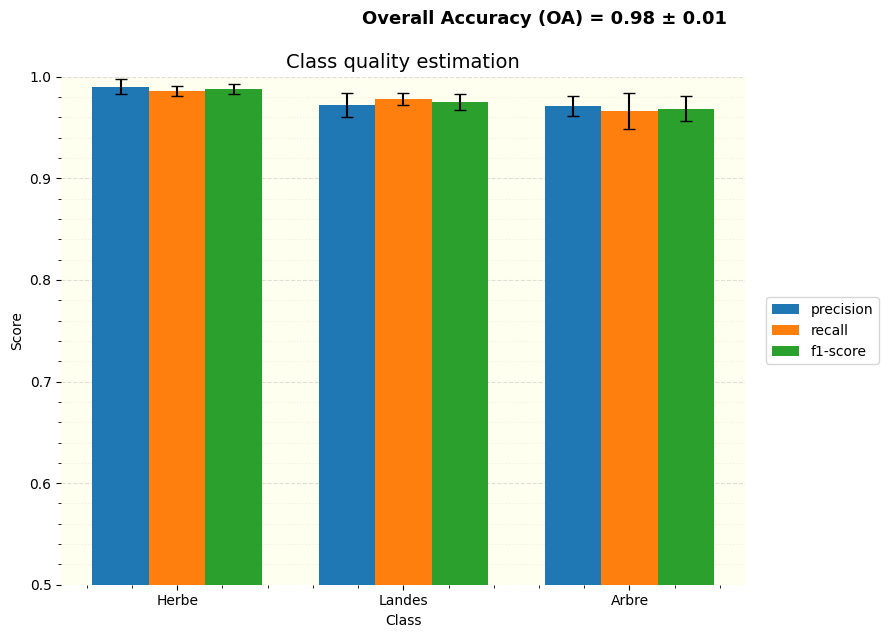

Graphique qualité des classes sauvegardé : /home/onyxia/work/results/figure/qualite_classes.png


In [25]:
array_cm = np.array(list_cm)
mean_cm= array_cm.mean(axis=0)

labels = ["Herbe", "Landes", "Arbre"]

plots.plot_cm(
    mean_cm,
    labels,
    out_filename=sortie_matrix,
    normalize=True
)

print("Matrice de confusion sauvegardée :", sortie_matrix)

# =========================
# Graphique qualité des classes
# =========================

print("Index du DataFrame :")
print(mean_df_report.index.tolist())

# Filtrer en excluant les lignes agrégées
exclude_rows = ['accuracy', 'macro avg', 'weighted avg']
class_mask = ~mean_df_report.index.isin(exclude_rows)

class_data = mean_df_report[class_mask]
class_std = std_df_report[class_mask]

print(f"\nNombre de classes filtrées : {len(class_data)}")

# Noms de classes lisibles
class_labels = ["Herbe", "Landes", "Arbre"]
metrics = ["precision", "recall", "f1-score"]

x = np.arange(len(class_labels))
width = 0.25

# Figure plus large
fig, ax = plt.subplots(figsize=(11, 6.5))

colors = {
    "precision": "#1f77b4",
    "recall": "#ff7f0e",
    "f1-score": "#2ca02c"
}

# Barres
for i, metric in enumerate(metrics):
    ax.bar(
        x + i * width,
        class_data[metric].values,
        width,
        yerr=class_std[metric].values,
        capsize=4,
        label=metric,
        color=colors[metric],
        zorder=2
    )

# Axes
ax.set_xticks(x + width)
ax.set_xticklabels(class_labels)
ax.set_ylim(0.5, 1)

ax.set_title("Class quality estimation", fontsize=14)
ax.set_ylabel("Score")
ax.set_xlabel("Class")

# OA au-dessus du graphique
fig.text(
    0.5, 0.96,
    f"Overall Accuracy (OA) = {mean_accuracy:.2f} ± {std_accuracy:.2f}",
    ha="center",
    va="center",
    fontsize=13,
    weight="bold"
)

# Légende à droite
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True
)

# Style graphique
ax.set_facecolor("ivory")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.minorticks_on()
ax.yaxis.grid(which="major", linestyle="--", alpha=0.4, zorder=1)
ax.yaxis.grid(which="minor", linestyle=":", alpha=0.2, zorder=1)

# Ajustement marges (place pour légende + OA)
plt.tight_layout(rect=[0, 0, 0.82, 0.93])

# Sauvegarde
plt.savefig(sortie_qualite, dpi=150)
plt.show()

print("Graphique qualité des classes sauvegardé :", sortie_qualite)


### Analyse de la matrice de confusion

La matrice de confusion normalisée montre que plus de 96 % des pixels de chaque classe sont correctement classés.

La classe **Herbe** est la mieux identifiée, avec environ 1.3 % de confusion avec les Landes et moins de 0.1 % avec les Arbres.
La classe **Landes** présente une confusion principale avec la classe Arbre (≈ 2.1 %).
La classe **Arbre** montre également une confusion modérée avec les Landes (≈ 2.6 %).

Les confusions impliquant la classe Herbe restent très faibles.

### Qualité des classes (precision, recall, F1-score)

Les trois classes présentent des performances élevées avec des F1-scores supérieurs à 0.97.

La classe **Herbe** obtient les meilleurs résultats (F1 ≈ 0.99), suivie des classes **Landes** et **Arbre** (F1 ≈ 0.97).

L’exactitude globale moyenne du modèle est de 0.98 ± 0.01, indiquant une excellente performance et une bonne stabilité.



### Carte finale

### Description de la méthode
La carte finale des strates végétales a été produite en appliquant le modèle Random Forest optimisé à l’ensemble des pixels du raster multibande Sentinel-2 (60 variables spectro-temporelles).

Le modèle est entraîné sur l’ensemble des échantillons disponibles puis appliqué pixel par pixel à l’image complète. Un masque spatial basé sur la bande B08 (proche infrarouge) est ensuite utilisé afin d’exclure les zones non végétalisées ou non pertinentes, en affectant la valeur NoData = 0.

La carte finale est enregistrée sous les caractéristiques suivantes :

Format : GeoTIFF

Type de données : uint8

Résolution spatiale : 10 m

Projection : EPSG:32630

Classes cartographiées : Herbe, Landes, Arbre

Image shape : (612, 1533, 60)

Affichage de la carte finale des strates végétales


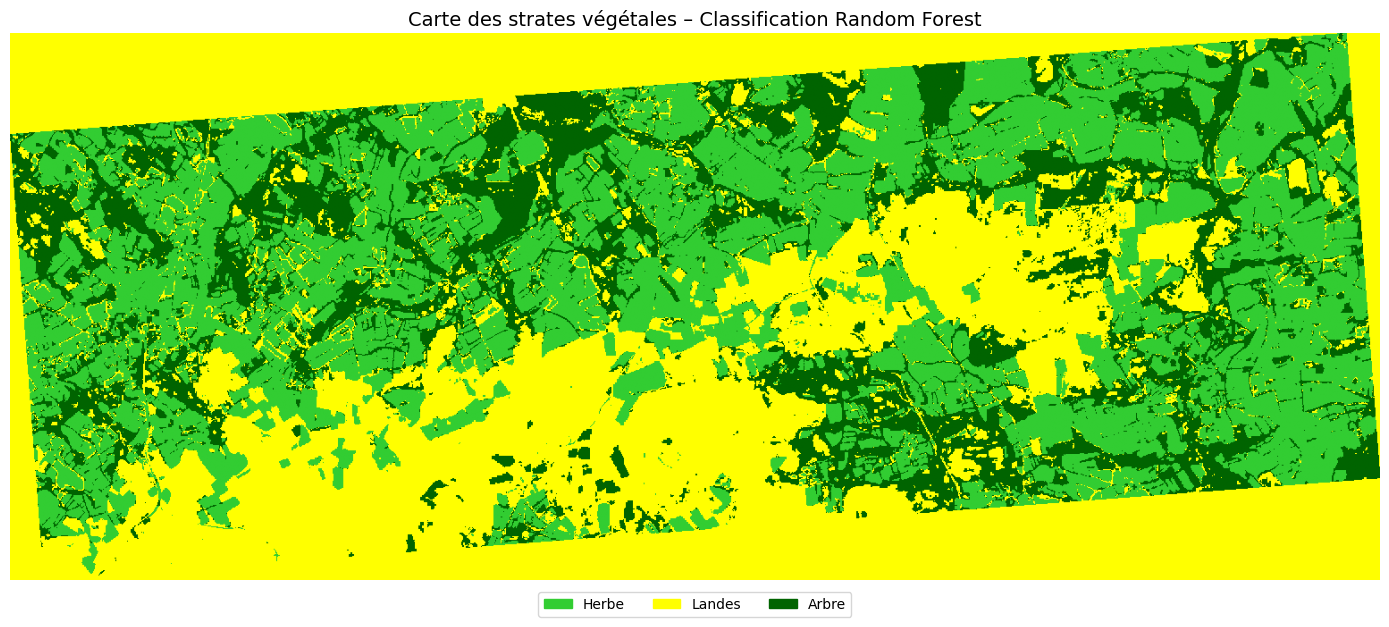

Carte finale créée : /home/onyxia/work/results/carte_strates.tif
Carte classifiée : /home/onyxia/work/results/carte_strates.tif
Masque B08 : /home/onyxia/work/data/projet_eval/bretagne_24-25_B08.tif
Pixels valides : 750040
Carte découpée créée : /home/onyxia/work/results/carte_strates.tif


'/home/onyxia/work/results/carte_strates.tif'

In [ ]:
# =========================
# Chargement image multibande
# =========================

multi_band_image_classification = out_stack

image_to_be_classified = rw.load_img_as_array(multi_band_image_classification)

rows, cols, bands = image_to_be_classified.shape
print("Image shape :", image_to_be_classified.shape)

# =========================
# Mise en forme pour classification
# =========================

X_image_to_be_classified = image_to_be_classified.reshape(rows * cols, bands)

# =========================
# Prédiction pixel par pixel
# =========================

y_pred = best_model.predict(X_image_to_be_classified)

# =========================
# Reconstruction image classifiée
# =========================

classified_image = y_pred.reshape(rows, cols)



# =========================
# Sauvegarde raster final
# =========================

sortie_classif = "/home/onyxia/work/results/carte_strates.tif"

ds_ref = gdal.Open(multi_band_image_classification)
driver = gdal.GetDriverByName("GTiff")

ds_out = driver.Create(
    sortie_classif,
    cols,
    rows,
    1,
    gdal.GDT_Byte   # uint8
)

ds_out.SetGeoTransform(ds_ref.GetGeoTransform())
ds_out.SetProjection(ds_ref.GetProjection())

band = ds_out.GetRasterBand(1)
band.WriteArray(classified_image.astype(np.uint8))
band.SetNoDataValue(0)

ds_out = None
ds_ref = None

print("Carte finale créée :", sortie_classif)

# Découpage de la carte classifiée avec masque B08

mf.mask_classification_with_b08(
    raster_classif_path="/home/onyxia/work/results/carte_strates.tif",
    raster_b08_path=os.path.join(DATA, "bretagne_24-25_B08.tif"),
    output_path="/home/onyxia/work/results/carte_strates.tif"  # écrase la carte finale
)



### Vérification nodata

In [27]:
ds = gdal.Open(sortie_classif)
band = ds.GetRasterBand(1)

# NoData
print("Valeur NoData :", band.GetNoDataValue())

# Type de données
dtype = gdal.GetDataTypeName(band.DataType)
print("Type de données :", dtype)

# Vérification automatique
if band.DataType == gdal.GDT_Byte:
    print("Format correct : image en UInt8 ")
else:
    print("Attention : format incorrect", dtype)

ds = None


Valeur NoData : 0.0
Type de données : Byte
Format correct : image en UInt8 


# DISCUSSION GÉNÉRALE

## Synthèse des résultats

Ce projet a permis de produire une carte de strates végétales (Herbe, Landes, Arbre) sur la zone d'étude bretonne avec une exactitude globale de **97.7% ± 0.8%**. Les performances par classe sont excellentes et homogènes (F1-score > 0.94 pour toutes les classes), témoignant de la robustesse du modèle Random Forest optimisé.

## Forces de l'approche

### 1. **Dimension spectro-temporelle exploitée**
L'utilisation de 10 bandes Sentinel-2 sur 6 dates (60 variables) a permis de capturer à la fois :
- La signature spectrale des strates (notamment red-edge sensible à la chlorophylle)
- La dynamique phénologique annuelle (cycles végétatifs différenciés)

L'analyse d'importance confirme la pertinence des bandes red-edge (B05-B07, B8A) et du proche infrarouge (B08), cohérent avec la littérature sur la discrimination de végétation.

### 2. **Optimisation rigoureuse**
La stratégie GridSearchCV avec validation croisée 5-fold stratifiée garantit :
- Exploration systématique de l'espace des hyperparamètres
- Évaluation robuste via métrique pondérée adaptée au déséquilibre
- Stabilité confirmée par les faibles écarts-types (< 0.8%)

### 3. **Qualité des échantillons**
Malgré le déséquilibre modéré (1022-1599 pixels/classe), la photo-interprétation assure une référence fiable. La rasterisation à 10m préserve la cohérence géométrique avec les images Sentinel-2.

## Limites et perspectives d'amélioration

### 1. **Indice ARI insuffisant seul**
L'analyse phénologique montre que l'ARI ne permet pas de discriminer efficacement les Landes des autres strates. Les profils temporels Herbe-Landes sont trop similaires. Cette limite justifie pleinement l'approche multivariée retenue, mais suggère que :
- D'autres indices spécifiques aux landes pourraient être testés (NDLI, CAI)
- L'intégration de données haute résolution (pléiades) améliorerait la détection des structures de landes

### 2. **Confusions résiduelles Landes-Arbre**
Bien que faibles, les confusions entre Landes et Arbre (F1 Arbre = 0.97) s'expliquent par :
- Formations arbustives de transition (landes hautes évoluant vers boisement)
- Résolution 10m pouvant mélanger pixels mixtes en zones de lisière
- Absence de données de hauteur (MNS/LiDAR) qui discrimineraient structure verticale

**Perspective** : fusion Sentinel-2 / Sentinel-1 (texture radar sensible à la structure) pourrait réduire ces confusions.

### 3. **Généralisation temporelle et spatiale**
- Modèle calibré sur année 2024-2025 : performances sur autres années à valider
- Zone d'étude limitée (Bretagne) : transférabilité vers autres contextes biogéographiques incertaine
- Absence de classe "Sol Nu" dans échantillons limite l'applicabilité à des zones anthropisées

**Perspective** : constitution base d'échantillons multi-sites et multi-années pour modèle robuste.

### 4. **Validation indépendante manquante**
La validation croisée interne est robuste mais insuffisante pour usage opérationnel. Une validation sur :
- Sites géographiquement distincts
- Données de vérité terrain indépendantes (relevés phytosociologiques)

serait nécessaire avant déploiement cartographique à grande échelle.

## Applicabilité opérationnelle

**Cas d'usage pertinents** :
- Suivi temporel des landes dans cadre gestion conservatoire (habitats Natura 2000)
- Détection changements d'occupation du sol (enfrichement, colonisation arbustive)
- Cartographie rapide à l'échelle régionale (disponibilité gratuite Sentinel-2)

**Limites d'usage** :
- Précision insuffisante pour applications nécessitant discrimination intra-landes (Calluna vs Erica)
- Zones hétérogènes ou pixels mixtes problématiques à 10m
- Mise à jour dépendante de disponibilité images sans nuages (contrainte climatique bretonne)

## Conclusion et ouvertures

Ce travail démontre la pertinence des approches Random Forest appliquées aux séries temporelles Sentinel-2 pour cartographie des strates végétales. Les performances obtenues (> 97%) sont compatibles avec un usage opérationnel de suivi à l'échelle régionale.

Les perspectives d'amélioration identifiées (fusion multi-capteurs, enrichissement échantillonnage, validation externe) constituent des axes de recherche appliquée prometteurs pour renforcer la robustesse et l'applicabilité de la méthode à des contextes élargis.

L'intégration de dimensions supplémentaires (topographie, pédologie, données historiques) dans un cadre de modélisation géospatiale pourrait également enrichir l'analyse et ouvrir vers des applications prédictives (modélisation de niche écologique, scénarios d'évolution).